# Design Acessível: Encontrando o Contraste Perfeito para Modos Claro e Escuro

**O dilema do modo escuro: como uma análise de dados revelou as cores que funcionam em qualquer lugar.**

Por: Aldéryck Albuquerque, 2025 (derycck@gmail.com | [in/alderyck/](https://www.linkedin.com/in/alderyck/))

**Contexto:**
- Cores são essenciais em design, mas o contraste é crucial para acessibilidade. No cenário de escolha de cor para se fazer anotações em apresentações, é importante garantir que o texto seja legível seja em fundo branco ou fundo preto. Desse modo, para cada cor essencial, mudanças em sua tonalidade (saturação, luminosidade/brilho) pode fazê-la com que possua um nível de contraste similar tanto em fundo branco, quanto em fundo escuro. A tonalidade ideal para cada cor essencial precisa ser encontrada.

**Problema:**
- Uma cor as vezes tem bom contraste em fundo branco, mas não em fundo preto. Isso prejudica a legibilidade.

Pergunta a ser respondida:
- Qual é o melhor tom de cada cor essencial para maximizar o contraste seja em fundo preto ou branco?


In [391]:
import re
import pandas as pd
import matplotlib.pyplot as plt


## Funções

In [ ]:
def hex_to_rgb(color: str) -> list[int]:
    """Converte uma cor em formato hexadecimal para valores RGB.

    Args:
        color: String representando a cor em formato hexadecimal
               Exemplos: "#FF0000", "FF0000", "#F00", "F00"

    Returns:
        Lista com três inteiros representando os valores RGB [R, G, B]
        no intervalo 0-255

    Raises:
        Exception: Se o formato da cor não for válido
    """
    result = re.match(r'^#?([a-f0-9]{3,3}|[a-f0-9]{6,6})$', color, re.IGNORECASE)

    if result is None:
        raise Exception('Could not extract color')

    result_list = list(result.group(1))

    if len(result_list) == 6:
        result_list = [result_list[i] + result_list[i+1] for i in range(0, len(result_list), 2)]
    else:
        result_list = [result_list[i] + result_list[i] for i in range(0, len(result_list))]
    # Convert to RGB
    return [int(hex_code, 16) for hex_code in result_list]

def calculate_luminance(color_code: int) -> float:
    """Converte um valor de canal de cor sRGB (0-255) para sua representação linear.

    Realiza a linearização de um único canal de cor (R, G ou B),
    convertendo do espaço não-linear sRGB para valores lineares necessários
    para cálculos precisos de luminância relativa.

    Fórmula oficial do padrão sRGB (WCAG) para conversão:
    - Para valores escuros (< 0.03928): relação quase linear
    - Para valores claros (≥ 0.03928): função de potência (γ = 2.4)

    Args:
        color_code: Valor do canal de cor no espaço sRGB (0-255)

    Returns:
        Valor linear correspondente (0.0-1.0) para uso em cálculos de luminância
    """
    index = float(color_code) / 255

    if index < 0.03928:
        return index / 12.92
    else:
        return ((index + 0.055) / 1.055) ** 2.4

def calculate_relative_luminance(rgb: list[int]) -> float:
    """
    Calcula a luminância relativa de uma cor RGB.

    A luminância relativa representa o brilho percebido de uma cor, levando em
    conta como o olho humano é sensível a diferentes comprimentos de onda de
    luz (vermelho, verde e azul).

    O olho humano é muito mais sensível à luz verde do que à vermelha, e muito
    menos sensível à luz azul. Por exemplo, um azul RGB (0, 0, 255) parece
    muito mais escuro do que um verde RGB (0, 255, 0).

    Para modelar essa percepção, a luminância relativa é calculada como uma
    soma ponderada dos valores lineares de R, G e B usando coeficientes padrão
    da indústria (ITU-R BT.709, usado para HDTVs e adotado pelo WCAG):
    - 0.2126 para o Vermelho (~21%)
    - 0.7152 para o Verde (~71%)
    - 0.0722 para o Azul (~7%)

    Estes pesos refletem diretamente a fisiologia do olho humano, onde o verde
    domina nossa percepção de brilho.

    Args:
        rgb: Lista com valores RGB no espaço sRGB (0-255) [R, G, B]

    Returns:
        Valor de luminância relativa (0.0-1.0), onde 0.0 é preto e 1.0 é branco
    """
    return 0.2126 * calculate_luminance(rgb[0]) + 0.7152 * calculate_luminance(rgb[1]) + 0.0722 * calculate_luminance(rgb[2])

def get_contrast(hex_1: str, hex_2: str) -> float:
    """
    Calcula a taxa de contraste entre duas cores hexadecimais conforme WCAG.

    A fórmula oficial para a taxa de contraste WCAG é:
    (L1 + 0.05) / (L2 + 0.05)

    Onde:
    - L1 é a luminância relativa da cor mais clara
    - L2 é a luminância relativa da cor mais escura
    - O +0.05 é um fator de compensação para evitar divisão por zero (quando
      uma cor é preto puro com L=0) e para considerar o brilho ambiente

    Args:
        hex_1: Primeira cor em formato hexadecimal (ex: "#FF0000", "FF0000")
        hex_2: Segunda cor em formato hexadecimal (ex: "#00FF00", "00FF00")

    Returns:
        Taxa de contraste como float (1.0 a 21.0), onde:
        - 1.0 = sem contraste (cores idênticas)
        - 21.0 = contraste máximo (preto vs branco)
        - ≥4.5 = recomendado para texto normal (AA)
        - ≥7.0 = recomendado para texto grande (AAA)

    Examples:
        >>> get_contrast("#000000", "#FFFFFF")  # Preto vs Branco
        21.0
        >>> get_contrast("#FF0000", "#FF0000")  # Vermelho vs Vermelho
        1.0
        >>> get_contrast("#0073E6", "#FFFFFF")  # Azul vs Branco
        4.52
    """
    color_one = hex_to_rgb(hex_1)
    color_two = hex_to_rgb(hex_2)

    color_one_lum = calculate_relative_luminance(color_one)
    color_two_lum = calculate_relative_luminance(color_two)

    light_lum = color_one_lum if color_one_lum > color_two_lum else color_two_lum
    dark_lum = color_one_lum if color_one_lum < color_two_lum else color_two_lum

    contrast_ratio = (light_lum + 0.05) / (dark_lum + 0.05)
    return contrast_ratio

In [ ]:
def rgb_to_hex(r, g, b):
    """
    Converte valores RGB para notação hexadecimal.
    r: Red (0-255)
    g: Green (0-255)
    b: Blue (0-255)
    """
    return f'#{r:02X}{g:02X}{b:02X}'

def hsb_to_rgb(h: float, s: float, b: float) -> tuple[int, int, int]:
    """
    Converte valores HSB (Hue, Saturation, Brightness) para notação RGB.
    h: Hue (0-360)
    s: Saturation (0-100)
    b: Brightness (0-100)
    """
    h = float(h) % 360  # Ensure hue is within 0-360
    s = float(s) / 100  # Convert to 0-1 range
    b = float(b) / 100  # Convert to 0-1 range

    c = b * s
    x = c * (1 - abs((h / 60) % 2 - 1))
    m = b - c

    if 0 <= h < 60:
        r, g, b_prime = c, x, 0
    elif 60 <= h < 120:
        r, g, b_prime = x, c, 0
    elif 120 <= h < 180:
        r, g, b_prime = 0, c, x
    elif 180 <= h < 240:
        r, g, b_prime = 0, x, c
    elif 240 <= h < 300:
        r, g, b_prime = x, 0, c
    elif 300 <= h < 360:
        r, g, b_prime = c, 0, x
    else:
        r, g, b_prime = 0, 0, 0

    r = int(round((r + m) * 255))
    g = int(round((g + m) * 255))
    b_final = int(round((b_prime + m) * 255))

    return r, g, b_final

def hsb_to_hex(h: float, s: float, b: float) -> str:
    """
    Converte valores HSB (Hue, Saturation, Brightness) para notação hexadecimal.
    h: Hue (0-360)
    s: Saturation (0-100)
    b: Brightness (0-100)
    """
    r, g, b_ = hsb_to_rgb(h, s, b)
    return rgb_to_hex(r, g, b_)

In [ ]:
def hsb_to_hsl(h: float, s: float, b: float) -> tuple[float, float, float]:
    """
    Converte valores HSB (Hue, Saturation, Brightness) para HSL (Hue, Saturation, Lightness).

    Args:
        h: Hue (0-360)
        s: Saturation (0-100)
        b: Brightness (0-100)

    Returns:
        tuple[float, float, float]: Valores HSL (H: 0-360, S: 0-100, L: 0-100)
    """
    # Normalizar valores para 0-1
    h_norm = float(h) % 360  # Garantir que H está entre 0-360
    s_norm = float(s) / 100  # Converter para 0-1
    b_norm = float(b) / 100  # Converter para 0-1

    # Calcular Lightness
    lightness = b_norm * (2 - s_norm) / 2

    # Calcular Saturation para HSL
    if lightness == 0 or lightness == 1:
        saturation_hsl = 0
    elif lightness <= 0.5:
        saturation_hsl = (b_norm * s_norm) / (2 * lightness)
    else:
        saturation_hsl = (b_norm * s_norm) / (2 - 2 * lightness)

    # Converter de volta para escala 0-100
    return (h_norm, int(round(saturation_hsl * 100, 0)), int(round(lightness * 100, 0)))

In [557]:
def plot_best_contrast(df: pd.DataFrame, col_contrast: str, col_hue: str, col_label_1: str, col_label_2: str, title: str) -> None:
    """
    Plota um gráfico de dispersão duplo mostrando contraste e dois parâmetros de cor por matiz.

    São dois eixos Y: O primeiro mostra os valores de contraste,
        E o segundo mostra dois parâmetros de cor (como saturação e brilho) em
        função da matiz (hue).

    Args:
        df: DataFrame contendo os dados de cores e contraste
        col_contrast: Nome da coluna com valores de contraste
        col_hue: Nome da coluna com valores de matiz (0-360)
        col_label_1: Nome da coluna do primeiro parâmetro (ex: saturação)
        col_label_2: Nome da coluna do segundo parâmetro (ex: brilho)
        title: Título do gráfico

    Returns:
        None: Exibe o gráfico usando matplotlib
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Primeiro eixo - contrast_max
    color = 'tab:red'
    ax1.set_xlabel(col_hue)
    ax1.set_ylabel(col_contrast, color='black')
    ax1.scatter(df[col_hue], df[col_contrast], color=color, alpha=0.7, label=col_contrast)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_title(title)

    # Definir limite do eixo Y
    ax1.set_ylim(3, 5)

    ax1.set_xticks(range(0, 361, 30))
    ax1.set_xticks(range(0, 361, 10), minor=True)

    # Adicionar linhas de grade vertical
    ax1.grid(True, axis='x', alpha=0.8, linestyle='-', linewidth=0.5)
    ax1.grid(True, which='minor', axis='x', alpha=0.7, linestyle='--', linewidth=0.4)

    # Segundo eixo
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    color3 = 'tab:green'
    ax2.set_ylabel(f'{col_label_1} / {col_label_2}', color='black')
    ax2.scatter(df[col_hue], df[col_label_1], color=color2, alpha=0.7, label=col_label_1, marker='s')
    ax2.scatter(df[col_hue], df[col_label_2], color=color3, alpha=0.7, label=col_label_2, marker='^')
    ax2.tick_params(axis='y', labelcolor='black')

    # Adicionar legendas
    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')
    return fig

In [ ]:
def create_color_palette_df(colors_rgb: list[tuple[int, int, int]]) -> pd.io.formats.style.Styler:
    """
    Exibe uma paleta de cores em fundo branco e preto usando pandas dataframe.

    Args:
        colors_rgb: Uma lista de tuplas, onde cada tupla contém os valores
                    (R, G, B) de uma cor. Ex: [(255, 0, 0), (0, 255, 0)]

    Returns:
        Um objeto pandas.io.formats.style.Styler pronto para ser exibido em um
        ambiente como o Jupyter Notebook.
    """
    if not colors_rgb:
        print("A lista de cores de entrada está vazia.")
        return pd.DataFrame().style

    # 1. Preparar os dados para o DataFrame
    # Converte as tuplas RGB (255, 0, 0) para strings "0-rgb(255, 0, 0)"
    color_strings = [f"{h}-rgb({r}, {g}, {b})" for h, r, g, b in colors_rgb]

    # Cria o DataFrame com duas colunas, ambas contendo as mesmas strings de cor
    df = pd.DataFrame({
        'Branco': color_strings,
        'Preto': color_strings
    })

    # 2. Definir a função de estilização
    def style_table(dataframe: pd.DataFrame) -> pd.DataFrame:
        """Aplica estilos CSS a todo o DataFrame de uma vez."""
        # Cria um novo DataFrame com a mesma estrutura, preenchido com strings vazias
        style_df = pd.DataFrame('', index=dataframe.index, columns=dataframe.columns)

        # Estilos comuns para todas as células
        common_style = (
            "padding: 0px 0px; "
            "min-width: 155px; "
            "font-weight: bold; "
            "font-size: 12px; "
            "text-align: center; "
        )

        # Obter nomes das colunas para aplicar estilos condicionalmente
        columns = dataframe.columns.tolist()

        # Aplicar estilos baseado na posição da coluna
        for i, col in enumerate(columns):
            if i % 2 == 0:  # Colunas pares (0, 2): fundo branco
                # Extrai a notação de cor RGB após o hífen e aplica o estilo
                style_df[col] = dataframe[col].apply(
                    lambda color: f"background-color: white; color: {color.split('-')[1]}; {common_style}"
                )
            else:  # Colunas ímpares (1, 3): fundo preto
                style_df[col] = dataframe[col].apply(
                    lambda color: f"background-color: black; color: {color.split('-')[1]}; {common_style}"
                )

        return style_df

    half: int = df.shape[0] // 2
    first_half = df.iloc[:half].reset_index(drop=True)
    second_half = df.iloc[half:].reset_index(drop=True)
    # Adicionar sufixos para distinguir colunas
    color_palette= pd.concat([
        first_half,
        second_half.add_suffix('.')
    ], axis=1)


    # 3. Aplicar os estilos e customizações finais
    styled_df = (color_palette.style
                .apply(style_table, axis=None)
                .set_caption("Cores de Contraste perfeito")
                .hide(axis='index')
                .set_table_styles([
                    {'selector': 'th.col_heading',
                     'props': [('text-align', 'center')]}
                ])
                )

    return styled_df

## Em busca do melhor contraste

**Notação HSB**

Hue, Saturação e Brilho é uma representação de cores intuitiva, onde mudanças no Brilho busca simular iluminação real, como incidência de luz ou reflexos em um objeto material.\
Nela, Hue (Matiz) representa a cor essencial em si (0°-360°).\
Brilho 0% é preto e 100% é a cor pura. O branco é atingido quando a saturação é 0% e o brilho é 100%.

**Criação de do dataframe base**

Com todos os contrastes calculados para cada cor possível no espaço de cor HSB.\
Também foi filtrado as cores de tonalidade excessivamente escuras (<40) e de baixa saturação (<50), para evitar a preferência por cores cinzas e até preta em fundo branco.

In [ ]:
%%time

black = hsb_to_hex(0,100,0)
white = hsb_to_hex(0,0,100)
color_list = []
for hue in range(0, 360, 5):
    for bright in range(40, 100+1):
        for saturation in range(50, 100+1):
            color = hsb_to_hex(hue, saturation, bright)
            contrast_1 = round(get_contrast(color, white), 2)
            contrast_2 = round(get_contrast(color, black), 2)
            contrast_diff = contrast_1 - contrast_2
            color_list.append(
                {'hue': hue, "b_hsb": bright, "s_hsb": saturation,
                 "contrast_1": contrast_1, "contrast_2": contrast_2,
                 "contrast_diff": abs(contrast_diff)})
df_total = (pd.DataFrame(color_list)
            .sort_values(by=['hue', 'contrast_diff', 'b_hsb', 's_hsb'], ascending=[True, True, False, False])
            )
df_total

CPU times: total: 4.05 s
Wall time: 4.04 s


,hue,b_hsb,s_hsb,contrast_1,contrast_2,contrast_diff
2478,0,88,80,4.58,4.58,0.00
2213,0,83,70,4.58,4.58,0.00
2698,0,92,96,4.59,4.58,0.01
2532,0,89,83,4.58,4.59,0.01
2425,0,87,78,4.58,4.59,0.01
...,...,...,...,...,...,...
220927,355,40,96,13.23,1.59,11.64
220928,355,40,97,13.27,1.58,11.69
220929,355,40,98,13.31,1.58,11.73
220930,355,40,99,13.35,1.57,11.78


**Melhor Contraste**

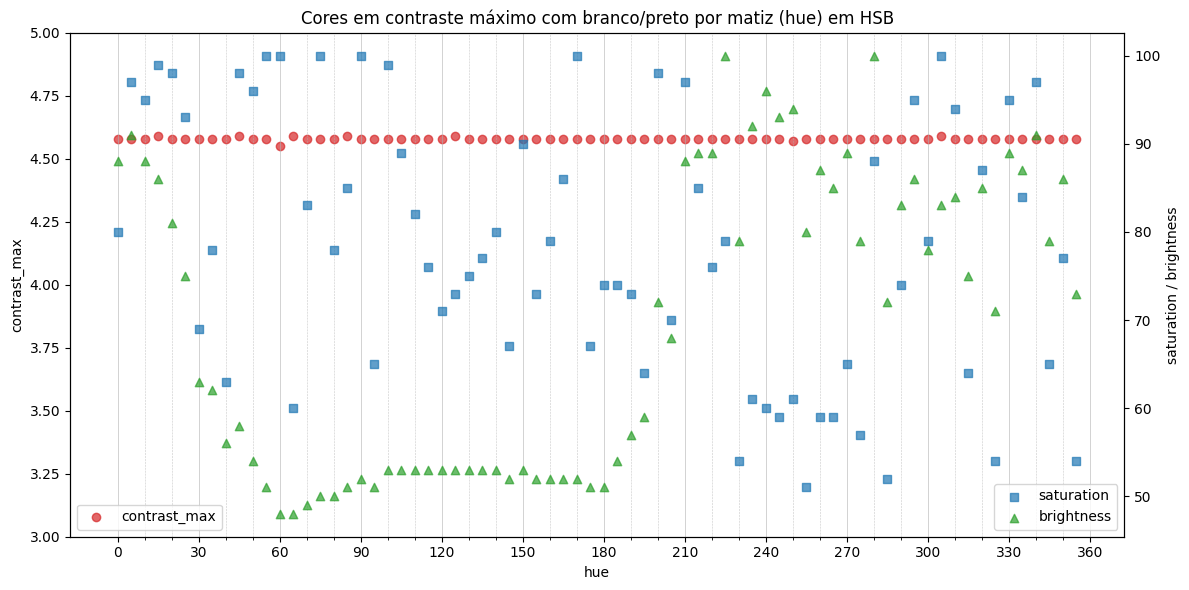

In [ ]:
df_best_contrast = (df_total
                    .rename(columns={'contrast_1': 'contrast_max'})
                    .reindex(columns=['hue', 's_hsb', 'b_hsb', 'contrast_max', 'contrast_diff'])
                    .drop_duplicates('hue', keep='first'))
df_best_contrast = (df_best_contrast
                    .rename(columns={'contrast_1': 'contrast_max'})
                    .sort_values('hue')
                    .reindex(columns=['hue', 's_hsb', 'b_hsb', 'contrast_max', 'contrast_diff'])
                    )
fig = plot_best_contrast(df_best_contrast.rename(columns={'s_hsb': 'saturation', 'b_hsb': 'brightness'}),
                   'contrast_max', 'hue', 'saturation', 'brightness',
                   'Cores em contraste máximo com branco/preto por matiz (hue) em HSB')
fig.savefig('./img/best_contrast_hue_HSB1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Após hue 200, o brilho e saturação ideais para maximizar contraste varia muito

In [261]:
df_best_contrast.query('hue>=280 and hue<=290')

,hue,saturation,bright,contrast_max,contrast_diff
177314,280,88,100,4.58,0.0
178961,285,52,72,4.58,0.0
182655,290,74,83,4.58,0.0


Isso pode ocorrer pois em busca de melhorar o contraste em 0.01 pontos, o que é pouco significante, o brilho e saturação podem variar muito em relação às matizes vizinhas.

In [263]:
df_total.query('hue==285').head()

,hue,saturation,bright,contrast_max,contrast_diff
178961,285,52,72,4.58,0.00
180278,285,94,97,4.59,0.01
180171,285,89,95,4.59,0.01
180065,285,85,93,4.58,0.01
179959,285,81,91,4.58,0.01


Para o Hue 280, o brilho ideal foi 100.\
Já para hue 285, o brilho ideal foi 72. Apesar de que se tolerarmos uma diminuição de 0.01 pontos na qualidade do contraste, o brilho passa a ser 97, bem próximo do brilho ideal para o hue 280.

Assim, buscando reduzir a variabilidade de brilho por diferenças insignificantes na qualidade do contraste, podemos escolher o maior brilho dentre as cores que possui uma variação pequena na qualidade do contraste.

Qual o número dessa variação pequena? Vamos descobrir.

Primeiro vamos encontrar a matiz que oferece o pior contraste.

In [363]:
df_worse_contrast = (df_total
                    .sort_values(by='contrast_diff', ascending=True)
                    .drop_duplicates('hue', keep='first')
                 )
df_worse_contrast

,hue,s_hsb,b_hsb,contrast_max,contrast_diff
2478,0,80,88,4.58,0.00
44045,70,82,49,4.58,0.00
203800,325,54,71,4.58,0.00
195170,310,94,84,4.58,0.00
197792,315,64,75,4.58,0.00
...,...,...,...,...,...
11621,15,94,84,4.59,0.01
47136,75,62,49,4.58,0.01
158315,250,61,94,4.57,0.02
40860,65,59,48,4.59,0.02


A cor amarela (hue 60) é a que tem maior diferença de contraste. Assim podemos usar seu valor como janela de variação para encontrar a cor que possui o brilho máximo.

In [550]:
worse_contrast = (df_worse_contrast['contrast_diff'].max())

In [635]:
df_best_contrast = (df_total
                    .query(f'contrast_diff<={worse_contrast}')
                    .sort_values(by='b_hsb', ascending=False)
                    .drop_duplicates('hue', keep='first')
                    .rename(columns={'contrast_1': 'contrast_max'})
                    .sort_values('hue')
                    .reindex(columns=['hue', 's_hsb', 'b_hsb', 'contrast_max', 'contrast_diff'])
                    )

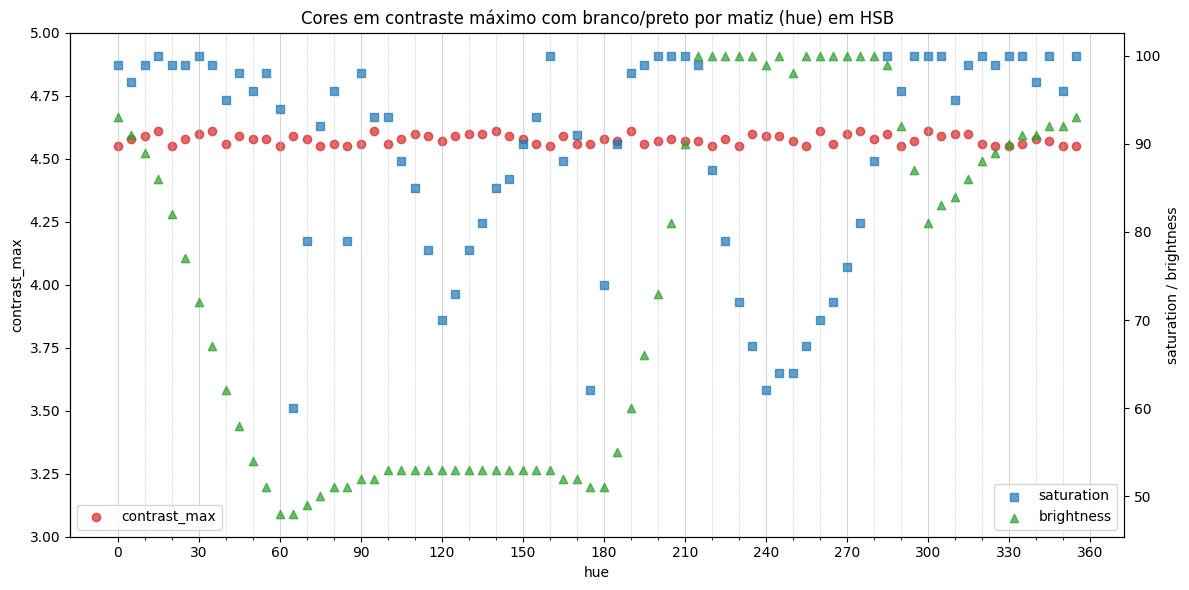

In [636]:
fig = plot_best_contrast(df_best_contrast.rename(columns={'s_hsb': 'saturation', 'b_hsb': 'brightness'}),
                   'contrast_max', 'hue', 'saturation', 'brightness',
                   'Cores em contraste máximo com branco/preto por matiz (hue) em HSB')
fig.savefig('./img/best_contrast_hue_HSB2.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

**Notação HSL**

Hue, Saturação e Luminosidade é uma representação de cores mais intuitiva que HSB (Hue, Saturação e Brilho).\
Com ela é mais fácil manter contraste visual entre elementos e criar paletas harmônicas com variações suaves de luz.\
Nela, Luminosidade 0% é preto, 100% é branco e 50% é a cor pura. 



In [572]:
hsl_values = df_best_contrast.apply(
    lambda row: hsb_to_hsl(row['hue'], row['s_hsb'], row['b_hsb']),
    axis=1
)
df_best_contrast_2 = df_best_contrast.assign(
        s_hsl=hsl_values.str[1],
        l_hsl=hsl_values.str[2]
    )
df_best_contrast_2

,hue,s_hsb,b_hsb,contrast_max,contrast_diff,s_hsl,l_hsl
2752,0,99,93,4.55,0.06,98,47
5759,5,97,91,4.58,0.00,94,47
8770,10,99,89,4.59,0.02,98,45
11729,15,100,86,4.61,0.05,100,43
14635,20,99,82,4.55,0.06,98,41
...,...,...,...,...,...,...,...
211088,335,100,91,4.56,0.04,100,46
214196,340,97,91,4.58,0.00,94,47
217361,345,100,92,4.57,0.03,100,46
220468,350,96,92,4.55,0.06,92,48


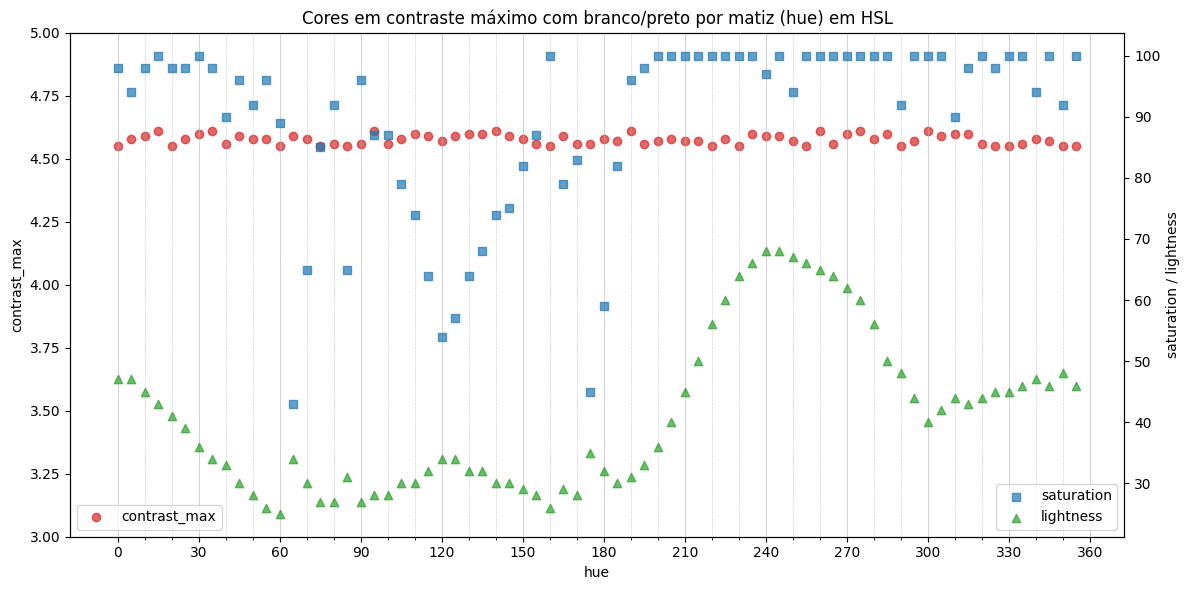

In [ ]:
fig = plot_best_contrast(df_best_contrast_2.rename(columns={'s_hsl': 'saturation', 'l_hsl': 'lightness'}),
                   'contrast_max', 'hue', 'saturation', 'lightness',
                   'Cores em contraste máximo com branco/preto por matiz (hue) em HSL')
fig.savefig('./img/best_contrast_hue_HSL.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Em HSL é possível visualizar com ainda mais clareza que cores quentes exigem menor luminosidade e cores frias exigem maior luminosidade para alcançar o contraste ideal.

**Adicionando RGB e HEX**

**RGB** é uma representação de cor de modo aditivo, o que significa que as cores são criadas pela adição de luz. Sua origem é baseada na teoria física da visão colorida tricomática de cores, que representa a forma como os monitores e telas funcionam.\
Quando os três componentes estão no valor máximo (255, 255, 255), o resultado é branco. Quando todos estão no mínimo (0, 0, 0), o resultado é preto.

**HEX** é uma representação de cor em formato hexadecimal, amplamente utilizada em design digital e desenvolvimento web. Ela é baseada no modelo RGB, onde cada componente (vermelho, verde e azul) é representado por dois dígitos hexadecimais, variando de 00 a FF.

In [375]:
rgb_values = df_best_contrast.apply(
    lambda row: hsb_to_rgb(row['hue'], row['s_hsb'], row['b_hsb']),
    axis=1
)
hex_values = df_best_contrast.apply(
    lambda row: hsb_to_hex(row['hue'], row['s_hsb'], row['b_hsb']),
    axis=1
)
df_best_contrast_3 = df_best_contrast_2.assign(
        r_rgb=rgb_values.str[0],
        g_rgb=rgb_values.str[1],
        b_rgb=rgb_values.str[2],
        hex=hex_values
    )
df_best_contrast_3

,hue,s_hsb,b_hsb,contrast_max,contrast_diff,s_hsl,l_hsl,r_rgb,g_rgb,b_rgb,hex
2752,0,99,93,4.55,0.06,98,47,237,2,2,#ED0202
5759,5,97,91,4.58,0.00,94,47,232,26,7,#E81A07
8770,10,99,89,4.59,0.02,98,45,227,40,2,#E32802
11729,15,100,86,4.61,0.05,100,43,219,55,0,#DB3700
14635,20,99,82,4.55,0.06,98,41,209,71,2,#D14702
...,...,...,...,...,...,...,...,...,...,...,...
211088,335,100,91,4.56,0.04,100,46,232,0,97,#E80061
214196,340,97,91,4.58,0.00,94,47,232,7,82,#E80752
217361,345,100,92,4.57,0.03,100,46,235,0,59,#EB003B
220468,350,96,92,4.55,0.06,92,48,235,9,47,#EB092F


**Tabelas resultante**

In [609]:
df_best_contrast_summary = (df_best_contrast_3
 .assign(HSB = lambda x: x.apply(lambda row: f"hsb({row['hue']:.0f}, {row['s_hsb']:.0f}, {row['b_hsb']:.0f})", axis=1))
 .assign(HSL= lambda x: x.apply(lambda row: f"hsl({row['hue']:.0f}, {row['s_hsl']:.0f}, {row['l_hsl']:.0f})", axis=1))
 .assign(RGB= lambda x: x.apply(lambda row: f"rgb({row['r_rgb']}, {row['g_rgb']}, {row['b_rgb']})", axis=1))
 .assign(list_colors = lambda x: x.apply(lambda row: (row['hue'], row['r_rgb'], row['g_rgb'], row['b_rgb']), axis=1))
 .reindex(columns=['hue', 'HSB', 'HSL', 'RGB', 'hex','list_colors'])
 # filtrar linhas cuja coluna hue seja divisível por 10
 .query('hue % 10 == 0')
)
df_best_contrast_summary

,hue,HSB,HSL,RGB,hex,list_colors
2752,0,"hsb(0, 99, 93)","hsl(0, 98, 47)","rgb(237, 2, 2)",#ED0202,"(0, 237, 2, 2)"
8770,10,"hsb(10, 99, 89)","hsl(10, 98, 45)","rgb(227, 40, 2)",#E32802,"(10, 227, 40, 2)"
14635,20,"hsb(20, 99, 82)","hsl(20, 98, 41)","rgb(209, 71, 2)",#D14702,"(20, 209, 71, 2)"
20348,30,"hsb(30, 100, 72)","hsl(30, 100, 36)","rgb(184, 92, 0)",#B85C00,"(30, 184, 92, 0)"
26055,40,"hsb(40, 95, 62)","hsl(40, 90, 33)","rgb(158, 108, 8)",#9E6C08,"(40, 158, 108, 8)"
31870,50,"hsb(50, 96, 54)","hsl(50, 92, 28)","rgb(138, 116, 6)",#8A7406,"(50, 138, 116, 6)"
37784,60,"hsb(60, 94, 48)","hsl(60, 89, 25)","rgb(122, 122, 7)",#7A7A07,"(60, 122, 122, 7)"
44042,70,"hsb(70, 79, 49)","hsl(70, 65, 30)","rgb(108, 125, 26)",#6C7D1A,"(70, 108, 125, 26)"
50383,80,"hsb(80, 96, 51)","hsl(80, 92, 27)","rgb(88, 130, 5)",#588205,"(80, 88, 130, 5)"
56658,90,"hsb(90, 98, 52)","hsl(90, 96, 27)","rgb(68, 133, 3)",#448503,"(90, 68, 133, 3)"


Em representação de json

In [610]:
df_best_contrast_summary.drop(columns=['list_colors']).to_dict('records')

[{'hue': 0,
  'HSB': 'hsb(0, 99, 93)',
  'HSL': 'hsl(0, 98, 47)',
  'RGB': 'rgb(237, 2, 2)',
  'hex': '#ED0202'},
 {'hue': 10,
  'HSB': 'hsb(10, 99, 89)',
  'HSL': 'hsl(10, 98, 45)',
  'RGB': 'rgb(227, 40, 2)',
  'hex': '#E32802'},
 {'hue': 20,
  'HSB': 'hsb(20, 99, 82)',
  'HSL': 'hsl(20, 98, 41)',
  'RGB': 'rgb(209, 71, 2)',
  'hex': '#D14702'},
 {'hue': 30,
  'HSB': 'hsb(30, 100, 72)',
  'HSL': 'hsl(30, 100, 36)',
  'RGB': 'rgb(184, 92, 0)',
  'hex': '#B85C00'},
 {'hue': 40,
  'HSB': 'hsb(40, 95, 62)',
  'HSL': 'hsl(40, 90, 33)',
  'RGB': 'rgb(158, 108, 8)',
  'hex': '#9E6C08'},
 {'hue': 50,
  'HSB': 'hsb(50, 96, 54)',
  'HSL': 'hsl(50, 92, 28)',
  'RGB': 'rgb(138, 116, 6)',
  'hex': '#8A7406'},
 {'hue': 60,
  'HSB': 'hsb(60, 94, 48)',
  'HSL': 'hsl(60, 89, 25)',
  'RGB': 'rgb(122, 122, 7)',
  'hex': '#7A7A07'},
 {'hue': 70,
  'HSB': 'hsb(70, 79, 49)',
  'HSL': 'hsl(70, 65, 30)',
  'RGB': 'rgb(108, 125, 26)',
  'hex': '#6C7D1A'},
 {'hue': 80,
  'HSB': 'hsb(80, 96, 51)',
  'HSL': 'hs

Em markdown

| hue | HSB               | HSL               | RGB               | hex     |
| --- | ----------------- | ----------------- | ----------------- | ------- |
| 0   | hsb(0, 99, 93)    | hsl(0, 98, 47)    | rgb(237, 2, 2)    | #ED0202 |
| 10  | hsb(10, 99, 89)   | hsl(10, 98, 45)   | rgb(227, 40, 2)   | #E32802 |
| 20  | hsb(20, 99, 82)   | hsl(20, 98, 41)   | rgb(209, 71, 2)   | #D14702 |
| 30  | hsb(30, 100, 72)  | hsl(30, 100, 36)  | rgb(184, 92, 0)   | #B85C00 |
| 40  | hsb(40, 95, 62)   | hsl(40, 90, 33)   | rgb(158, 108, 8)  | #9E6C08 |
| 50  | hsb(50, 96, 54)   | hsl(50, 92, 28)   | rgb(138, 116, 6)  | #8A7406 |
| 60  | hsb(60, 94, 48)   | hsl(60, 89, 25)   | rgb(122, 122, 7)  | #7A7A07 |
| 70  | hsb(70, 79, 49)   | hsl(70, 65, 30)   | rgb(108, 125, 26) | #6C7D1A |
| 80  | hsb(80, 96, 51)   | hsl(80, 92, 27)   | rgb(88, 130, 5)   | #588205 |
| 90  | hsb(90, 98, 52)   | hsl(90, 96, 27)   | rgb(68, 133, 3)   | #448503 |
| 100 | hsb(100, 93, 53)  | hsl(100, 87, 28)  | rgb(51, 135, 9)   | #338709 |
| 110 | hsb(110, 85, 53)  | hsl(110, 74, 30)  | rgb(39, 135, 20)  | #278714 |
| 120 | hsb(120, 70, 53)  | hsl(120, 54, 34)  | rgb(41, 135, 41)  | #298729 |
| 130 | hsb(130, 78, 53)  | hsl(130, 64, 32)  | rgb(30, 135, 47)  | #1E872F |
| 140 | hsb(140, 85, 53)  | hsl(140, 74, 30)  | rgb(20, 135, 59)  | #14873B |
| 150 | hsb(150, 90, 53)  | hsl(150, 82, 29)  | rgb(14, 135, 74)  | #0E874A |
| 160 | hsb(160, 100, 53) | hsl(160, 100, 26) | rgb(0, 135, 90)   | #00875A |
| 170 | hsb(170, 91, 52)  | hsl(170, 83, 28)  | rgb(12, 133, 112) | #0C8570 |
| 180 | hsb(180, 74, 51)  | hsl(180, 59, 32)  | rgb(34, 130, 130) | #228282 |
| 190 | hsb(190, 98, 60)  | hsl(190, 96, 31)  | rgb(3, 128, 153)  | #038099 |
| 200 | hsb(200, 100, 73) | hsl(200, 100, 36) | rgb(0, 124, 186)  | #007CBA |
| 210 | hsb(210, 100, 90) | hsl(210, 100, 45) | rgb(0, 115, 230)  | #0073E6 |
| 220 | hsb(220, 87, 100) | hsl(220, 100, 56) | rgb(33, 107, 255) | #216BFF |
| 230 | hsb(230, 72, 100) | hsl(230, 100, 64) | rgb(71, 102, 255) | #4766FF |
| 240 | hsb(240, 62, 99)  | hsl(240, 97, 68)  | rgb(96, 96, 252)  | #6060FC |
| 250 | hsb(250, 64, 98)  | hsl(250, 94, 67)  | rgb(117, 90, 250) | #755AFA |
| 260 | hsb(260, 70, 100) | hsl(260, 100, 65) | rgb(136, 77, 255) | #884DFF |
| 270 | hsb(270, 76, 100) | hsl(270, 100, 62) | rgb(158, 61, 255) | #9E3DFF |
| 280 | hsb(280, 88, 100) | hsl(280, 100, 56) | rgb(180, 31, 255) | #B41FFF |
| 290 | hsb(290, 96, 92)  | hsl(290, 92, 48)  | rgb(197, 9, 235)  | #C509EB |
| 300 | hsb(300, 100, 81) | hsl(300, 100, 40) | rgb(207, 0, 207)  | #CF00CF |
| 310 | hsb(310, 95, 84)  | hsl(310, 90, 44)  | rgb(214, 11, 180) | #D60BB4 |
| 320 | hsb(320, 100, 88) | hsl(320, 100, 44) | rgb(224, 0, 150)  | #E00096 |
| 330 | hsb(330, 100, 90) | hsl(330, 100, 45) | rgb(230, 0, 115)  | #E60073 |
| 340 | hsb(340, 97, 91)  | hsl(340, 94, 47)  | rgb(232, 7, 82)   | #E80752 |
| 350 | hsb(350, 96, 92)  | hsl(350, 92, 48)  | rgb(235, 9, 47)   | #EB092F |

In [630]:
list_colors = df_best_contrast_summary['list_colors'].to_list()
color_palette = create_color_palette_df(list_colors)
color_palette

Branco,Preto,Branco.,Preto.
"0-rgb(237, 2, 2)","0-rgb(237, 2, 2)","180-rgb(34, 130, 130)","180-rgb(34, 130, 130)"
"10-rgb(227, 40, 2)","10-rgb(227, 40, 2)","190-rgb(3, 128, 153)","190-rgb(3, 128, 153)"
"20-rgb(209, 71, 2)","20-rgb(209, 71, 2)","200-rgb(0, 124, 186)","200-rgb(0, 124, 186)"
"30-rgb(184, 92, 0)","30-rgb(184, 92, 0)","210-rgb(0, 115, 230)","210-rgb(0, 115, 230)"
"40-rgb(158, 108, 8)","40-rgb(158, 108, 8)","220-rgb(33, 107, 255)","220-rgb(33, 107, 255)"
"50-rgb(138, 116, 6)","50-rgb(138, 116, 6)","230-rgb(71, 102, 255)","230-rgb(71, 102, 255)"
"60-rgb(122, 122, 7)","60-rgb(122, 122, 7)","240-rgb(96, 96, 252)","240-rgb(96, 96, 252)"
"70-rgb(108, 125, 26)","70-rgb(108, 125, 26)","250-rgb(117, 90, 250)","250-rgb(117, 90, 250)"
"80-rgb(88, 130, 5)","80-rgb(88, 130, 5)","260-rgb(136, 77, 255)","260-rgb(136, 77, 255)"
"90-rgb(68, 133, 3)","90-rgb(68, 133, 3)","270-rgb(158, 61, 255)","270-rgb(158, 61, 255)"


![Resultado](./img/results.png)